# [“Learning From Protein Structure with Geometric Vector Perceptrons”](https://openreview.net/pdf?id=1YLJDvSx6J4)
### A mini tutorial in applied Geometric Deep Learning.

TODO:
- show model implementation.
- make sure model is ev/iv.

We will be building a small model with an architecture similar to that of GVP, using the [MD17 dataset](https://arxiv.org/abs/2007.09593), which contains moleculewise energies ($\text{kcal}/\text{mole}$) and atomwise forces ($\text{kcal}/\text{mole}/\text{Angstrom}$).

To build a principled model, let‘s begin with the essential question in GDL: *what are the symmetries in our data?*

...

......

We would like our model’s energy prediction to be invariant to translation, rotation, and reflection (we say “invariant to $E(3)$”), and we would like its force predictions to be equivariant to the same (“equivariant to $E(3)$”). We would also like it to be equivariant to permutations of the nodes, since molecules do not come with canonical atom numberings.

The implementation of our model is a bit bulky for this presentation, so it is hidden, but you can verify via GitHub (if you really care) that each operation in this model is  by construction $E(3)$ and node-permutation equivariant.

We put our model through a brief training run and log its losses.

First, some imports.

In [1]:
import torch
from torch_geometric.datasets import MD17
from MiniPAINN import Model
from data_get_utils import get_mini_dataloader, get_molecule
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from train import mini_train
from model_utils import get_random_roto_reflection_translation, E3_transform_molecule, E3_transform_force, plot_molecules, plot_molecules_with_forces

torch.manual_seed(2002)

Now, the training run.

In [2]:
model = Model()

mini_train(model=model,
      rho=0.99,
      num_items=512,
      batch_size=32,
      num_epochs=8)

/usr/local/Caskroom/miniconda/base/envs/GDL/lib/python3.11/site-packages/torch_geometric/data/dataset.py:239: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(


RuntimeError: The size of tensor a (16) must match the size of tensor b (3) at non-singleton dimension 1

It’s not very impressive that we get a good-looking loss plot. Our model has a lot of parameters and the dummy training set we’ve made is pretty small.

Much cooler is the assurance that our model behaves sensibly when we modify our data.

Let’s get a benzene molecule from the dataset.

In [3]:
molecule = get_molecule(type='benzene')

Let’s check out this molecule’s atoms’ positions in space.

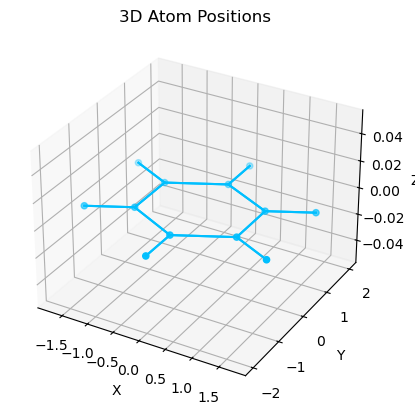

In [5]:
plot_molecules(molecules=[molecule],
               colors=['deepskyblue'],
               labels=[''])

Next, let’s generate a random roto-reflection-translation. We rotate the molecule by a random rotation in 3-space, slide it in a random direction up to a distance of 1, and flip its orientation with probability 50%.

In [6]:
roto_reflection_translation = get_random_roto_reflection_translation()

Random roto-reflection:

	-0.488 -0.010 -0.873

	-0.508 -0.810  0.293

	-0.710  0.586  0.390

Random translation:

	 0.268

	 0.703

	-0.618



Let’s update our molecule’s atoms’ positions based on this roto-reflection-translation.

In [7]:
transformed_molecule = E3_transform_molecule(molecule, roto_reflection_translation)

Let’s plot their positions in space compared to their original ones.

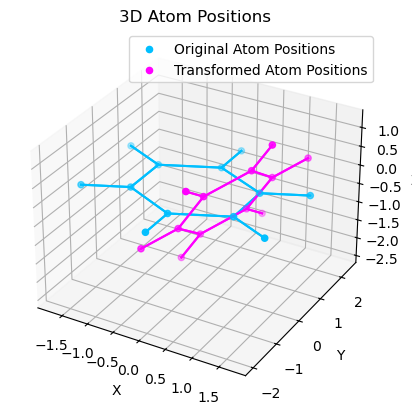

In [10]:
plot_molecules(molecules=[molecule, transformed_molecule], 
               colors=['deepskyblue', 'magenta'], 
               labels=['Original Atom Positions', 'Transformed Atom Positions'])

This gives some assurance that we have, indeed, acted on our molecule, and that our action is in $E(3)$. We haven’t warped or sheared it, for example.

Let’s see how our model deals with our original and our transformed data.

In [11]:
transformed_energy_prediction, transformed_force_predictions = model(transformed_molecule) # energy invariant
original_energy_prediction, original_force_predictions = model(molecule)

We must verify that the model’s energy prediction is invariant to $E(3)$.

In [26]:
print(f'Predicted energy of the original molecule:    {original_energy_prediction.item(): 6.3f}.')
print(f'Predicted energy of the transformed molecule: {transformed_energy_prediction.item(): 6.3f}.')

Predicted energy of the original molecule:     0.364.
Predicted energy of the transformed molecule:  0.364.


Plotting the force predictions on each atom...

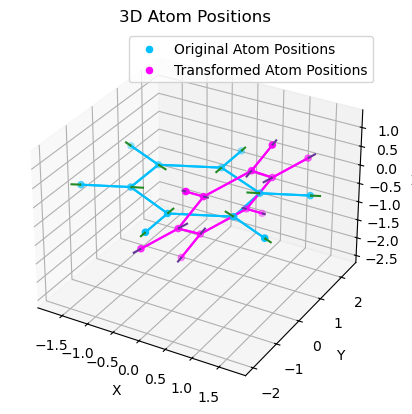

In [27]:
plot_molecules_with_forces(molecules=[molecule, transformed_molecule],
                           forces=[original_force_predictions, transformed_force_predictions],
                           colors=[['deepskyblue','forestgreen'],['magenta','rebeccapurple']],
                           labels=['Original Atom Positions', 'Transformed Atom Positions'])

The predictions are, of course, different! The molecules are positioned and oriented differently in space.

Yet if we put the force predictions through the same transformation as the molecule went through, we should get the same result. In other words, $f(g \circ x) = g \circ f(x)$. Let’s transform the force predictions on the original molecule...

In [13]:
transformed_original_force_predictions = E3_transform_force(original_force_predictions, roto_reflection_translation)

... and compare them to the force predictions on the transformed molecule.

In [21]:
print('Force predictions on the molecule transformed by our random roto-reflection-translation:\n f(g • x) =')
for row in transformed_force_predictions:
    print(f'\t{row[0].item(): 6.3f} {row[1].item(): 6.3f} {row[2].item(): 6.3f}')
print('Force predictions, transformed by the same random roto-reflection-translation, on the original molecule:\n g • f(x) =')
for row in transformed_original_force_predictions:
    print(f'\t{row[0].item(): 6.3f} {row[1].item(): 6.3f} {row[2].item(): 6.3f}')

Force predictions on the molecule transformed by our random roto-reflection-translation:
 f(g • x) =
	-0.006 -0.208  0.141
	-0.097 -0.198 -0.072
	-0.098 -0.015 -0.205
	 0.006  0.208 -0.141
	 0.097  0.198  0.072
	 0.098  0.015  0.205
	 0.000  0.170 -0.123
	 0.081  0.161  0.063
	 0.077  0.008  0.166
	-0.000 -0.170  0.123
	-0.081 -0.161 -0.063
	-0.077 -0.008 -0.166
Force predictions, transformed by the same random roto-reflection-translation, on the original molecule:
 g • f(x) =
	 0.264  0.493 -0.466
	 0.166  0.510 -0.697
	 0.168  0.683 -0.829
	 0.272  0.913 -0.769
	 0.370  0.896 -0.538
	 0.368  0.723 -0.406
	 0.270  0.870 -0.741
	 0.348  0.860 -0.558
	 0.347  0.711 -0.447
	 0.266  0.536 -0.494
	 0.188  0.546 -0.677
	 0.189  0.695 -0.789


Up to floating point sloppiness, they are the same! Our model is $E(3)$-equivariant, and we reap all the benefits that geometric model design promises.